___
## (1) Import Libraries
- Start by importing the necessary libraries and datasets

In [1]:
import os
from dateutil.relativedelta import relativedelta
import math
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV, LinearRegression
from statsmodels.formula.api import ols, glm
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, average_precision_score, f1_score, 
                             ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
pd.set_option('display.max_columns', None)

(1.1) Import the dataset

In [2]:
cc_default = pd.read_csv('data/credit card_defaults.csv')
# data = pd.read_excel('/data/credit_card_defaults.xlsx')

In [3]:
cc_default.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


___
## (2) Exploratory Data Analysis

In [4]:
cc_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   BILL_AMT1                   30000 non-null  int64
 7   BILL_AMT2                   30000 non-null  int64
 8   BILL_AMT3                   30000 non-null  int64
 9   BILL_AMT4                   30000 non-null  int64
 10  BILL_AMT5                   30000 non-null  int64
 11  BILL_AMT6                   30000 non-null  int64
 12  PAY_AMT1                    30000 non-null  int64
 13  PAY_AMT2                    30000 non-null  int64
 14  PAY_AM

In [5]:
cc_default.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [6]:
cc_default['ID'].nunique()

30000

Checked that there are no duplicate IDs

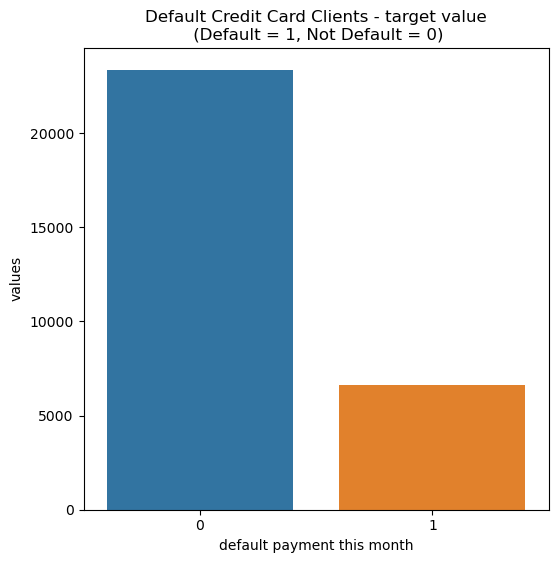

In [7]:
temp = cc_default["default payment this month"].value_counts()
df = pd.DataFrame({'default payment this month': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value\n (Default = 1, Not Default = 0)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default payment this month', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

In [8]:
cc_default["default payment this month"].value_counts()

0    23364
1     6636
Name: default payment this month, dtype: int64

Number of defaults make up 28.4% of the data set. Degree of imbalance is mild. No undersampling required

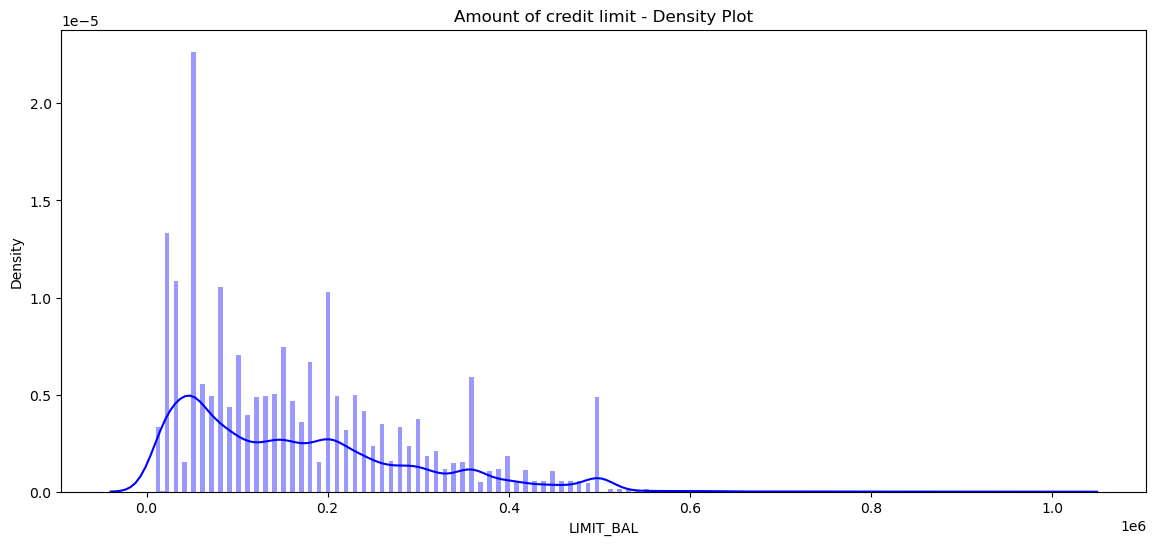

In [9]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.distplot(cc_default['LIMIT_BAL'],kde=True,bins=200, color="blue")
plt.show()

In [10]:
cc_default['LIMIT_BAL'].value_counts()

50000      3365
20000      1976
30000      1610
80000      1567
200000     1528
           ... 
730000        2
1000000       1
327680        1
760000        1
690000        1
Name: LIMIT_BAL, Length: 81, dtype: int64

___
## (3) Data preprocessing

In [11]:
cc_default["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

Based on data dictionary, only have 4 levels for education column. Convert all other values to others (value of 4)

In [12]:
cc_default.loc[cc_default["EDUCATION"] == 0, "EDUCATION"] = 4

In [13]:
cc_default.loc[cc_default["EDUCATION"] > 4, "EDUCATION"] = 4

In [14]:
cc_default["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [15]:
cc_default["MARRIAGE"].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Based on data dictionary, only have 3 categories for marriage column. Convert all 0 to others (value of 3)

In [16]:
cc_default.loc[cc_default["MARRIAGE"] == 0, "MARRIAGE"] = 3

In [17]:
cc_default["MARRIAGE"].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

#### 3.1 Create new features

3.1.1 Outstanding balance counts and DPD_90days column

If there is an increase in card balances that are not repaid (defined as 90+ days past the due date of repayment), the regulator will ask the bank to hold more capital – resulting in a direct cost to the bank. Attempt to create a new feature based on past 3 months data

In [18]:
cc_default_1 = cc_default.copy()

Created a copy of the dataframe to preserve original data

In [19]:
cc_default_1

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


Created new dataframe to prevent original dataframe from being overwritten

Created 3 new column OB (outstanding balance). Assuming that the BILL_AMT columns represent the total cumulative bill amount for each customer for the respective past month, then if bill amount is less than or equal to 0, means customer have paid their bills on time. If not, they would have an outstanding bill.

In [20]:
OB_1 = []

for i in cc_default_1['BILL_AMT1']:
    if i <= 0 : OB_1.append(0)
    
    
    else: OB_1.append(1)
        
        
cc_default_1['OB_1'] = OB_1    


In [21]:
OB_2 = []

for j in cc_default_1['BILL_AMT2']:
    if j <= 0 : OB_2.append(0)
    
    
    else: OB_2.append(1)
        
        
cc_default_1['OB_2'] = OB_2 

In [22]:
OB_3 = []

for k in cc_default_1['BILL_AMT2']:
    if k <= 0 : OB_3.append(0)
    
    
    else: OB_3.append(1)
        
        
cc_default_1['OB_3'] = OB_3

If count value of columns OB_1, OB_2 and OB_3 are added together and gives a value of 3, means that customers have outstanding bill for the last 3 months. Indicate as 1 for those who have 90 days past due date for their bill payment.

In [23]:
cc_default_1['Count_OB'] = cc_default_1['OB_1'] + cc_default_1['OB_2'] + cc_default_1['OB_3']

In [24]:
DPD_90days = []

for i in cc_default_1['Count_OB']:
    if i == 3: DPD_90days.append(1)
    
    else: DPD_90days.append(0)
        
        
cc_default_1['DPD_90days'] = DPD_90days

In [25]:
cc_default_1

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,1,1,3,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,1,1,3,1
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,1,1,3,1
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,1,1,3,1
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,1,1,1,3,1
29996,29997,150000,1,3,2,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,1,1,1,3,1
29997,29998,30000,1,2,2,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,1,1,1,3,1
29998,29999,80000,1,3,1,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,0,1,1,2,0


In [26]:
cc_default_1['DPD_90days'].value_counts()

1    26016
0     3984
Name: DPD_90days, dtype: int64

3.1.2 Average bill & pay amount from past 6 months

In [27]:
cc_default_1['avg_bill'] = (cc_default_1['BILL_AMT1'] + cc_default_1['BILL_AMT2'] + cc_default_1['BILL_AMT3'] + cc_default_1['BILL_AMT4'] + cc_default_1['BILL_AMT5'] + cc_default_1['BILL_AMT6']) / 6

In [28]:
cc_default_1['avg_paid'] = (cc_default_1['PAY_AMT1'] + cc_default_1['PAY_AMT2'] + cc_default_1['PAY_AMT3'] + cc_default_1['PAY_AMT4'] + cc_default_1['PAY_AMT5'] + cc_default_1['PAY_AMT6']) / 6

In [29]:
cc_default_1

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,1,1,3,1,1284.000000,114.833333
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,1,1,3,1,2846.166667,833.333333
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,1,1,3,1,16942.166667,1836.333333
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,1,1,3,1,38555.666667,1398.000000
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,1,1,3,1,18223.166667,9841.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,1,1,1,3,1,120891.500000,7091.666667
29996,29997,150000,1,3,2,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,1,1,1,3,1,3530.333333,2415.000000
29997,29998,30000,1,2,2,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,1,1,1,3,1,11749.333333,5216.666667
29998,29999,80000,1,3,1,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,0,1,1,2,0,44435.166667,24530.166667


3.1.3 Net worth column based on percentile of credit limit balance for each ID

We use credit limit balance to determine net worth, as most banks determine their credit limit from the income of the customer.

Considering top 25 percent of limit balance as high net worth, in between to be affluent and remaining 25 percent to be mass affluent. Indicate 3 levels of net worth in the column values. (1 = mass affluent, 2 = affluent and 3 = high net worth)

In [30]:
high_net_worth, affluent = cc_default_1.LIMIT_BAL.quantile(.75),cc_default_1.LIMIT_BAL.quantile(.25)

In [31]:
high_net_worth, affluent

(240000.0, 50000.0)

In [32]:
cc_default_1['Net_worth'] = pd.cut(x = cc_default_1.LIMIT_BAL,bins = [0,affluent,high_net_worth,5555555], labels = [1, 2, 3], include_lowest=True)

In [33]:
cc_default_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   ID                          30000 non-null  int64   
 1   LIMIT_BAL                   30000 non-null  int64   
 2   SEX                         30000 non-null  int64   
 3   EDUCATION                   30000 non-null  int64   
 4   MARRIAGE                    30000 non-null  int64   
 5   AGE                         30000 non-null  int64   
 6   BILL_AMT1                   30000 non-null  int64   
 7   BILL_AMT2                   30000 non-null  int64   
 8   BILL_AMT3                   30000 non-null  int64   
 9   BILL_AMT4                   30000 non-null  int64   
 10  BILL_AMT5                   30000 non-null  int64   
 11  BILL_AMT6                   30000 non-null  int64   
 12  PAY_AMT1                    30000 non-null  int64   
 13  PAY_AMT2        

In [34]:
cc_default_1['Net_worth'] = cc_default_1['Net_worth'].astype('int')

In [35]:
cc_default_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  int64  
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   BILL_AMT1                   30000 non-null  int64  
 7   BILL_AMT2                   30000 non-null  int64  
 8   BILL_AMT3                   30000 non-null  int64  
 9   BILL_AMT4                   30000 non-null  int64  
 10  BILL_AMT5                   30000 non-null  int64  
 11  BILL_AMT6                   30000 non-null  int64  
 12  PAY_AMT1                    30000 non-null  int64  
 13  PAY_AMT2                    300

In [36]:
cc_default_1['Net_worth'].value_counts()

2    15257
1     7676
3     7067
Name: Net_worth, dtype: int64

In [37]:
cc_default_1

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,1,1,3,1,1284.000000,114.833333,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,1,1,3,1,2846.166667,833.333333,2
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,1,1,3,1,16942.166667,1836.333333,2
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,1,1,3,1,38555.666667,1398.000000,1
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,1,1,3,1,18223.166667,9841.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,1,1,1,3,1,120891.500000,7091.666667,2
29996,29997,150000,1,3,2,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,1,1,1,3,1,3530.333333,2415.000000,2
29997,29998,30000,1,2,2,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,1,1,1,3,1,11749.333333,5216.666667,1
29998,29999,80000,1,3,1,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,0,1,1,2,0,44435.166667,24530.166667,2


___
## (4) Train Test Split

#### (4.1) Create the X and y datasets by dropping or keeping the target variable column

In [38]:
X = cc_default_1.drop(columns=['default payment this month'])
y = cc_default_1['default payment this month']

In [39]:
X

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,1,3,1,1284.000000,114.833333,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,1,3,1,2846.166667,833.333333,2
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,1,1,1,3,1,16942.166667,1836.333333,2
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,1,1,1,3,1,38555.666667,1398.000000,1
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,1,1,1,3,1,18223.166667,9841.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,1,1,1,3,1,120891.500000,7091.666667,2
29996,29997,150000,1,3,2,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,1,1,1,3,1,3530.333333,2415.000000,2
29997,29998,30000,1,2,2,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,1,1,3,1,11749.333333,5216.666667,1
29998,29999,80000,1,3,1,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,0,1,1,2,0,44435.166667,24530.166667,2


In [40]:
y

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment this month, Length: 30000, dtype: int64

#### (4.2) Perform train test split
- Use ratio of train-test 80/20, and set random state as 1

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [42]:
X_train

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
28004,28005,20000,2,2,2,30,20128,17842,18979,7886,19786,20025,0,7027,1000,19000,6000,1000,1,1,1,3,1,17441.000000,5671.166667,1
8560,8561,50000,2,2,1,32,316,282,316,316,316,316,282,350,316,316,316,316,1,1,1,3,1,310.333333,316.000000,1
15484,15485,180000,1,1,1,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,2
12531,12532,20000,2,2,2,50,5100,2940,6050,3100,0,0,2940,6050,3100,0,0,1035,1,1,1,3,1,2865.000000,2187.500000,1
24473,24474,340000,1,1,2,49,1190,2988,390,1489,2140,1190,2988,390,1489,2140,1190,1190,1,1,1,3,1,1564.500000,1564.500000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17289,17290,170000,2,3,1,40,179399,41265,20619,19520,5200,0,0,2000,1136,1000,0,36679,1,1,1,3,1,44333.833333,6802.500000,2
5192,5193,330000,2,1,1,41,4122,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,687.000000,0.000000,3
12172,12173,50000,1,2,2,22,49551,42517,35458,19778,19929,19790,1707,1321,687,705,811,874,1,1,1,3,1,31170.500000,1017.500000,1
235,236,80000,1,1,2,35,7988,3977,6848,1719,1378,19942,3983,6853,1719,1378,19942,2418,1,1,1,3,1,6975.333333,6048.833333,2


In [43]:
X_test

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
10747,10748,310000,1,3,1,32,172772,152397,110375,84373,57779,14163,8295,6000,4000,3000,1000,2000,1,1,1,3,1,98643.166667,4049.166667,3
12573,12574,10000,2,3,1,49,32,-358,-748,1690,1138,930,0,0,2828,0,182,0,1,0,0,1,0,447.333333,501.666667,1
29676,29677,50000,1,2,1,28,430,0,46257,45975,1300,43987,0,46257,2200,1300,43987,1386,1,0,0,1,0,22991.500000,15855.000000,1
8856,8857,80000,2,3,1,52,36649,39448,40101,40748,39816,40607,3700,1600,1600,0,1600,1600,1,1,1,3,1,39561.500000,1683.333333,2
21098,21099,270000,1,1,2,34,20979,17228,20924,22448,15490,17343,0,4000,2000,0,2000,2000,1,1,1,3,1,19068.666667,1666.666667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26329,26330,350000,2,2,2,34,-20,630,630,15722,2003,7264,650,0,15788,10,7299,13980,0,1,1,2,0,4371.500000,6287.833333,3
29693,29694,380000,1,2,2,30,47765,47945,135167,95527,91541,92808,3000,90527,5000,3000,4000,3000,1,1,1,3,1,85125.500000,18087.833333,3
16605,16606,50000,1,2,2,31,228,3183,5455,7629,6354,4655,2955,2500,2500,2526,2000,1500,1,1,1,3,1,4584.000000,2330.166667,1
19704,19705,20000,2,2,1,31,5500,8360,6000,0,0,0,3000,1000,0,0,0,0,1,1,1,3,1,3310.000000,666.666667,1


#### (4.3) At this point, the `ID` column is still in our X datasets. It is not a column that we should use for prediction, so we should drop it. Before that, store the `ID` column of the X_test DataFrame as a variable called `X_test_id` (which we will use later)

In [44]:
X_test_id = X_test['ID']

In [45]:
X_test_id

10747    10748
12573    12574
29676    29677
8856      8857
21098    21099
         ...  
26329    26330
29693    29694
16605    16606
19704    19705
12785    12786
Name: ID, Length: 6000, dtype: int64

#### (4.4) Drop the `ID` column from both X_train and X_test DataFrames

In [46]:
X_train = X_train.drop(columns=['ID'])
X_test = X_test.drop(columns=['ID'])

___
## (5) Model Training and Hyperparameter Tuning

### (5.1) Model 1 - XGBoost model

In [47]:
xgb_params = {'max_depth': [3, 5, 6, 8, 9, 10, 11], # Maximum depth of a tree
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5], # Step size shrinkage used in update to prevents overfitting
              'subsample': np.arange(0.4, 1.0, 0.1), #specifies the subsample ratio of the training instances that are randomly sampled without replacement to train each tree in the ensemble.
              'colsample_bytree': np.arange(0.3, 1.0, 0.1), # specifies the subsample ratio of the features that are randomly sampled without replacement to train each tree in the ensemble
              'colsample_bylevel': np.arange(0.3, 1.0, 0.1),# specifies the subsample ratio of the features that are randomly sampled without replacement to train each tree at each level. 
              'n_estimators': np.arange(100, 600, 100), #specifies the number of trees (estimators) to be used in the ensemble.
              'gamma': np.arange(0, 0.7, 0.1)} #controls the minimum reduction in the loss function required to make a split during tree building

# Loss function refers to the difference between the predicted y value with the actual y value. Eg. Mean Squared Error (MSE)

# Create RandomizedSearchCV instance

xgb_grid = RandomizedSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                      random_state=42),
                              param_distributions=xgb_params, 
                              cv=5, 
                              verbose=2,
                              n_iter=50,
                              scoring = recall_score
                             ) 

# cv specify the number of cross-validation folds to be used during the hyperparameter tuning process.
# verbose determines the verbosity level of the search process, meaning how much information about the progress and results of the search is printed to the console.
# verbose=0: No output will be printed during the search process.
# verbose=1: Some output will be printed, such as the progress of each iteration and the best parameters found so far.
# verbose=2: More detailed output will be printed, including the results of each iteration and the parameters tried.

# Run XGBoost grid search
xgb_grid.fit(X_train, y_train)

# Get best XGBoost model (based on best parameters) and predict on test set
xgb_best = xgb_grid.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=9, n_estimators=400, subsample=0.7999999999999999; total time=   5.8s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=9, n_estimators=400, subsample=0.7999999999999999; total time=   4.5s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=9, n_estimators=400, subsample=0.7999999999999999; total time=   4.9s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=9, n_estimators=400, subsample=0.7999999999999999; total time=   4.5s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.0, learning_rate=0.1, max_depth=9, n_estimators=400, subsample=0.7999999999999999; total time=   4.6s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.4, gamma=0.1, learning_rate=0.2, max_depth=5, n_esti

[CV] END colsample_bylevel=0.3, colsample_bytree=0.4, gamma=0.6000000000000001, learning_rate=0.3, max_depth=8, n_estimators=500, subsample=0.5; total time=   5.3s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.4, gamma=0.6000000000000001, learning_rate=0.3, max_depth=8, n_estimators=500, subsample=0.5; total time=   5.5s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.4, gamma=0.6000000000000001, learning_rate=0.3, max_depth=8, n_estimators=500, subsample=0.5; total time=   5.6s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.4, gamma=0.6000000000000001, learning_rate=0.3, max_depth=8, n_estimators=500, subsample=0.5; total time=   5.5s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=400, subsample=0.5; total time=   3.1s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.01, max_depth=3, n_estimators=400, subsample=0.5; tot

[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.6000000000000001, learning_rate=0.3, max_depth=8, n_estimators=500, subsample=0.8999999999999999; total time=  11.3s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.6000000000000001, learning_rate=0.3, max_depth=8, n_estimators=500, subsample=0.8999999999999999; total time=  14.6s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.0, learning_rate=0.2, max_depth=8, n_estimators=300, subsample=0.8999999999999999; total time=   5.1s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.0, learning_rate=0.2, max_depth=8, n_estimators=300, subsample=0.8999999999999999; total time=   5.1s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.9000000000000001, gamma=0.0, learning_rate=0.2, max_depth=8, n_estimators=300, subsample=0.8999999999999999; total time=   4.5s
[CV] END colsample_bylevel=0.3, colsample_byt

[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.30000000000000004, learning_rate=0.2, max_depth=11, n_estimators=200, subsample=0.7; total time=   5.7s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.30000000000000004, learning_rate=0.2, max_depth=11, n_estimators=200, subsample=0.7; total time=   6.1s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.30000000000000004, learning_rate=0.2, max_depth=11, n_estimators=200, subsample=0.7; total time=   6.1s
[CV] END colsample_bylevel=0.7000000000000002, colsample_bytree=0.9000000000000001, gamma=0.30000000000000004, learning_rate=0.2, max_depth=11, n_estimators=200, subsample=0.7; total time=   5.8s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.4, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.8999999999999999; total time=   1.0s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4

[CV] END colsample_bylevel=0.5, colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=9, n_estimators=400, subsample=0.7; total time=   6.6s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=9, n_estimators=400, subsample=0.7; total time=   6.4s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.8000000000000003, gamma=0.4, learning_rate=0.3, max_depth=11, n_estimators=300, subsample=0.8999999999999999; total time=   9.9s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.8000000000000003, gamma=0.4, learning_rate=0.3, max_depth=11, n_estimators=300, subsample=0.8999999999999999; total time=  10.0s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.8000000000000003, gamma=0.4, learning_rate=0.3, max_depth=11, n_estimators=300, subsample=0.8999999999999999; total time=  10.2s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.8000000000000003, gamma=0.4, learning_rate=0.3, m

[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.7999999999999999; total time=   3.2s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.7999999999999999; total time=   3.3s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.7999999999999999; total time=   3.4s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.7999999999999999; total time=   3.3s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.4; total time=   4.0s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.4; total time=   4.0s
[CV] END col

In [48]:
xgb_grid.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

___
## (6) Generate Prediction

#### With the model from the previous section, generate two sets of prediction output from the test set (X_test)
- Prediction probabilities (save it as an array in a new variable named `y_preds_proba`
- Label predictions (save it as an array in a new variable named `y_preds`

#### (6.1) Model 1 (XGBoost model) Predictions

In [49]:
preds_proba_1 = xgb_best.predict_proba(X_test)

y_preds_proba_1 = preds_proba_1[:,1]

y_preds_1 = xgb_best.predict(X_test)

___
## (7) Model Evaluation

#### (7.1) Using the predictions and the true values in the test set, evaluate the model performance by calculating the following metrics (rounded to 2 decimal places)
- Accuracy
- Recall
- F1 score
- ROC-AUC Score
- AUC-PR Score (aka Average Precision Score)

In [50]:
print("XGB accuracy score",round(accuracy_score(y_test, y_preds_1),2))
print(classification_report(y_test, y_preds_1))

XGB accuracy score 0.79
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      4663
           1       0.56      0.21      0.31      1337

    accuracy                           0.79      6000
   macro avg       0.68      0.58      0.59      6000
weighted avg       0.75      0.79      0.75      6000



In [51]:
round(accuracy_score(y_test, y_preds_1), 2)

0.79

In [52]:
round(recall_score(y_test, y_preds_1), 2)

0.21

In [53]:
round(f1_score(y_test, y_preds_1), 2)

0.31

In [54]:
round(roc_auc_score(y_test, y_preds_proba_1), 2)

0.72

In [55]:
round(average_precision_score(y_test, y_preds_proba_1), 2)

0.43

#### (7.2) Confusion Matrix and Score

In [56]:
confusion_matrix(y_test, y_preds_1)

array([[4437,  226],
       [1050,  287]], dtype=int64)

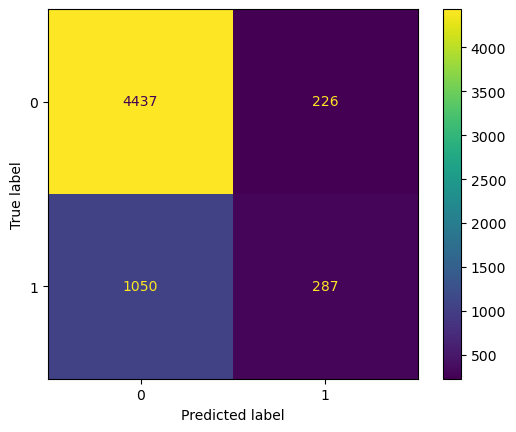

In [57]:
display(ConfusionMatrixDisplay.from_predictions(y_test, y_preds_1))

#### Calculate the percentages of false positives and false negatives

In [58]:
conf_mat = confusion_matrix(y_test, y_preds_1)

print(f"% of True Positive: {conf_mat[1][1]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")

print(f"% of True Negative: {conf_mat[0][0]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")

print(f"% of False Positive: {conf_mat[0][1]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")

print(f"% of False Negative: {conf_mat[1][0]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")

% of True Positive: 4.783333333333333
% of True Negative: 73.95
% of False Positive: 3.7666666666666666
% of False Negative: 17.5


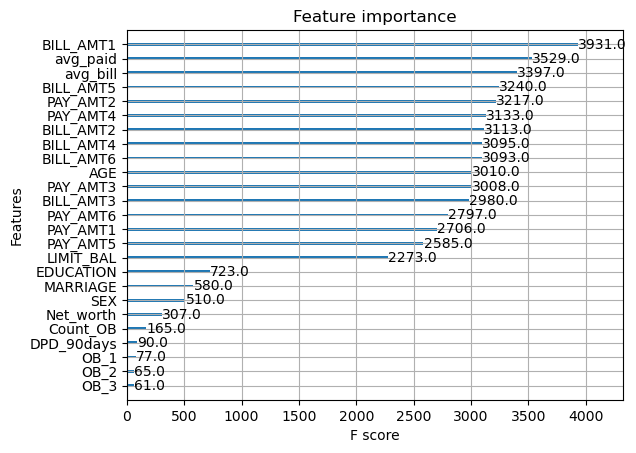

In [59]:
plot_importance(xgb_best)
plt.show()

### (8) Based on feature importance, drop columns with relatively lower importance scores. Then rerun the model

(8.1) Based on the feature importance plot for xgb_best model, drop columns for EDUCATION, SEX, MARRIAGE, Net_worth, Count_OB, OB_1, DPD_90days, OB_2 and OB_3 for X_train and X_test dataframes, and rename the new data frame

In [60]:
X_train2 = X_train.drop(columns = ['EDUCATION', 'SEX', 'MARRIAGE','Net_worth','Count_OB','OB_1','DPD_90days','OB_2','OB_3'])

In [61]:
X_test2 = X_test.drop(columns = ['EDUCATION', 'SEX', 'MARRIAGE','Net_worth','Count_OB','OB_1','DPD_90days','OB_2','OB_3'])

In [62]:
xgb_params2 = {'max_depth': [3, 5, 6, 8, 9, 10, 11], # Maximum depth of a tree
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5], # Step size shrinkage used in update to prevents overfitting
              'subsample': np.arange(0.4, 1.0, 0.1), #specifies the subsample ratio of the training instances that are randomly sampled without replacement to train each tree in the ensemble.
              'colsample_bytree': np.arange(0.3, 1.0, 0.1), # specifies the subsample ratio of the features that are randomly sampled without replacement to train each tree in the ensemble
              'colsample_bylevel': np.arange(0.3, 1.0, 0.1),# specifies the subsample ratio of the features that are randomly sampled without replacement to train each tree at each level. 
              'n_estimators': np.arange(100, 600, 100), #specifies the number of trees (estimators) to be used in the ensemble.
              'gamma': np.arange(0, 0.7, 0.1)} #controls the minimum reduction in the loss function required to make a split during tree building

# Loss function refers to the difference between the predicted y value with the actual y value. Eg. Mean Squared Error (MSE)

# Create RandomizedSearchCV instance

xgb_grid2 = RandomizedSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                                      random_state=42),
                              param_distributions=xgb_params2, 
                              cv=5, 
                              verbose=2,
                              n_iter=50,
                              scoring = recall_score
                             ) 

# cv specify the number of cross-validation folds to be used during the hyperparameter tuning process.
# verbose determines the verbosity level of the search process, meaning how much information about the progress and results of the search is printed to the console.
# verbose=0: No output will be printed during the search process.
# verbose=1: Some output will be printed, such as the progress of each iteration and the best parameters found so far.
# verbose=2: More detailed output will be printed, including the results of each iteration and the parameters tried.

# Run XGBoost grid search
xgb_grid2.fit(X_train2, y_train)

# Get best XGBoost model (based on best parameters) and predict on test set
xgb_best2 = xgb_grid2.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bylevel=0.8000000000000003, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.4; total time=   1.0s
[CV] END colsample_bylevel=0.8000000000000003, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.4; total time=   1.0s
[CV] END colsample_bylevel=0.8000000000000003, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.4; total time=   1.1s
[CV] END colsample_bylevel=0.8000000000000003, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.4; total time=   1.1s
[CV] END colsample_bylevel=0.8000000000000003, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.4; total time=   1.1s
[CV] END colsample_bylevel=0.80000000000000

[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.7000000000000002, gamma=0.2, learning_rate=0.3, max_depth=11, n_estimators=300, subsample=0.6; total time=   6.0s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.8s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.8s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.8s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.8s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.0, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.8s


[CV] END colsample_bylevel=0.3, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.5, max_depth=3, n_estimators=500, subsample=0.6; total time=   3.1s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.5, max_depth=3, n_estimators=500, subsample=0.6; total time=   3.1s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.7000000000000002, gamma=0.4, learning_rate=0.5, max_depth=3, n_estimators=500, subsample=0.6; total time=   2.8s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.6000000000000001, gamma=0.6000000000000001, learning_rate=0.5, max_depth=5, n_estimators=300, subsample=0.4; total time=   2.3s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.6000000000000001, gamma=0.6000000000000001, learning_rate=0.5, max_depth=5, n_estimators=300, subsample=0.4; total time=   2.5s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.6000000000000001, gamma=0.6000000000000001, learning_rate=0.5, max_depth=5, n_estimators=300, subsa

[CV] END colsample_bylevel=0.3, colsample_bytree=0.8000000000000003, gamma=0.5, learning_rate=0.3, max_depth=5, n_estimators=400, subsample=0.4; total time=   2.9s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.8000000000000003, gamma=0.5, learning_rate=0.3, max_depth=5, n_estimators=400, subsample=0.4; total time=   3.0s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.5, max_depth=11, n_estimators=400, subsample=0.8999999999999999; total time=   7.8s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.5, max_depth=11, n_estimators=400, subsample=0.8999999999999999; total time=   7.7s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.5, max_depth=11, n_estimators=400, subsample=0.8999999999999999; total time=   7.8s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.9000000000000001, gamma=0.4, learning_rate=0.5, max_depth=11, n_estimators=400, s

[CV] END colsample_bylevel=0.3, colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7999999999999999; total time=   3.9s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7999999999999999; total time=   4.2s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7999999999999999; total time=   4.2s
[CV] END colsample_bylevel=0.3, colsample_bytree=0.5, gamma=0.0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7999999999999999; total time=   4.1s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.6000000000000001, learning_rate=0.5, max_depth=3, n_estimators=400, subsample=0.4; total time=   2.1s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.7000000000000002, gamma=0.6000000000000001, learning_rate=0.5, max_depth=3, n_estimators=400, subsample=0.4; t

[CV] END colsample_bylevel=0.4, colsample_bytree=0.3, gamma=0.30000000000000004, learning_rate=0.3, max_depth=10, n_estimators=500, subsample=0.5; total time=   5.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.3, gamma=0.30000000000000004, learning_rate=0.3, max_depth=10, n_estimators=500, subsample=0.5; total time=   5.2s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=11, n_estimators=200, subsample=0.4; total time=   3.1s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=11, n_estimators=200, subsample=0.4; total time=   3.0s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=11, n_estimators=200, subsample=0.4; total time=   3.3s
[CV] END colsample_bylevel=0.9000000000000001, colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=11, n_estimators=200, subsample=0.4; total time=   3.2s
[CV] END

In [63]:
xgb_grid2.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8000000000000003, colsample_bynode=None,
              colsample_bytree=0.7000000000000002, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

(8.2) Generate new set of predictions based on the 2nd model

In [64]:
preds_proba_2 = xgb_best2.predict_proba(X_test2)

y_preds_proba_2 = preds_proba_2[:,1]

y_preds_2 = xgb_best2.predict(X_test2)

(8.3) Evaluation of model 2

In [65]:
print("XGB accuracy score",round(accuracy_score(y_test, y_preds_2),2))
print(classification_report(y_test, y_preds_2))

XGB accuracy score 0.79
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      4663
           1       0.59      0.18      0.27      1337

    accuracy                           0.79      6000
   macro avg       0.70      0.57      0.57      6000
weighted avg       0.76      0.79      0.74      6000



In [66]:
round(accuracy_score(y_test, y_preds_2), 2)

0.79

In [67]:
round(recall_score(y_test, y_preds_2), 2)

0.18

In [68]:
round(f1_score(y_test, y_preds_2), 2)

0.27

In [69]:
round(roc_auc_score(y_test, y_preds_proba_2), 2)

0.73

In [70]:
round(average_precision_score(y_test, y_preds_proba_2), 2)

0.46

(8.4) Confusion matrix for model 2

In [71]:
confusion_matrix(y_test, y_preds_2)

array([[4500,  163],
       [1100,  237]], dtype=int64)

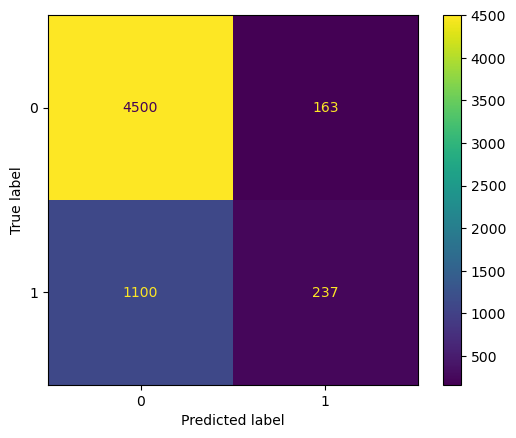

In [72]:
display(ConfusionMatrixDisplay.from_predictions(y_test, y_preds_2))

In [73]:
conf_mat = confusion_matrix(y_test, y_preds_2)

print(f"% of True Positive: {conf_mat[1][1]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")

print(f"% of True Negative: {conf_mat[0][0]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")

print(f"% of False Positive: {conf_mat[0][1]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")

print(f"% of False Negative: {conf_mat[1][0]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")

% of True Positive: 3.95
% of True Negative: 75.0
% of False Positive: 2.716666666666667
% of False Negative: 18.333333333333332


Based on comparison of evaluation metrics, both models have very similar scores. We will proceed to use model 1 for our recommendations

### (5.2) Model 3 - Logistics Regression

In [74]:
lr = LogisticRegression()
lr.fit(X_train2, y_train)
y_pred_lr = lr.predict(X_test2)

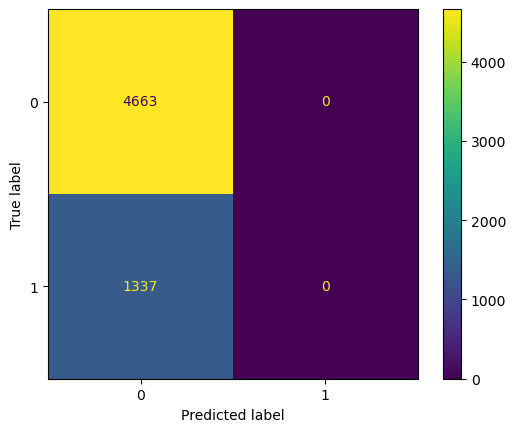

In [75]:
display(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr))

In [76]:
print("LR_Base accuracy score",round(accuracy_score(y_test, y_pred_lr),2))
print(classification_report(y_test, y_pred_lr))

LR_Base accuracy score 0.78
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      4663
           1       0.00      0.00      0.00      1337

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.60      0.78      0.68      6000



In [77]:
import statsmodels.formula.api as sm
import statsmodels.api as sm_api

X_train_c = sm_api.add_constant(X_train2)
X_test_c = sm_api.add_constant(X_test2)

In [78]:
model = sm_api.Logit(y_train, X_train_c)
result = model.fit()
result.summary()

         Current function value: 0.506444
         Iterations: 35


C:\Users\Ming\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default payment this month   No. Observations:                24000
Model:                                  Logit   Df Residuals:                    23983
Method:                                   MLE   Df Model:                           16
Date:                        Sun, 18 Feb 2024   Pseudo R-squ.:                 0.04066
Time:                                16:22:55   Log-Likelihood:                -12155.
converged:                              False   LL-Null:                       -12670.
Covariance Type:                    nonrobust   LLR p-value:                3.690e-209
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0532      0.063    -16.717      0.000      -1.177      -0.930
LIMIT_BAL  -2.787e-06   1.59e-07    -17.584      0.000    -3.1e-06   -2.48e-06
AGE            0.0096      0.002      5.704      0.000       0.006       0.013
BILL_AMT1  -2.193e-06      2.072  -1.06e-06      1.000      -4.061       4.061
BILL_AMT2   9.325e-06      2.072    4.5e-06      1.000      -4.061       4.061
BILL_AMT3   6.034e-06      2.072   2.91e-06      1.000      -4.061       4.061
BILL_AMT4   6.926e-06      2.072   3.34e-06      1.000      -4.061       4.061
BILL_AMT5   7.781e-06      2.072   3.76e-06      1.000      -4.061       4.061
BILL_AMT6    6.75e-06      2.072   3.26e-06      1.000      -4.061       4.061
PAY_AMT1      -0.0001        nan        nan        nan         nan         nan
PAY_AMT2      -0.0001        nan        nan        nan         nan         nan
PAY_AMT3      -0.0001        nan        nan        nan         nan         nan
PAY_AMT4      -0.0001        nan        nan        nan         nan         nan
PAY_AMT5   -9.893e-05        nan        nan        nan         nan         nan
PAY_AMT6   -9.394e-05        nan        nan        nan         nan         nan
avg_bill   -3.011e-05     12.431  -2.42e-06      1.000     -24.365      24.365
avg_paid       0.0006        nan        nan        nan         nan         nan
==============================================================================
"""

___
## (9) Recommendations

Based on prediction probability, create a new column Propensity, which refers to the predicted propensity of the customer to default on the credit card bill payment

In [79]:
cust_default_propensity = pd.DataFrame({'ID': X_test_id,
                                      'PROPENSITY': y_preds_proba_1})

In [80]:
cust_default_propensity.sort_values(by=['PROPENSITY'], ascending=False).head(10)


,ID,PROPENSITY
20721,20722,0.972560
29991,29992,0.970646
5837,5838,0.960959
13966,13967,0.960824
20520,20521,0.956299
10801,10802,0.952843
20902,20903,0.951734
28054,28055,0.951178
18094,18095,0.940669
2050,2051,0.936123


Merge the data frame with the original dataframe, based on the customer ID

In [81]:
cust_default_propensity  = cust_default_propensity.merge(cc_default_1,
                                    on=['ID'],
                                    how='left')

In [82]:
cust_default_propensity

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth
0,10748,0.023053,310000,1,3,1,32,172772,152397,110375,84373,57779,14163,8295,6000,4000,3000,1000,2000,0,1,1,1,3,1,98643.166667,4049.166667,3
1,12574,0.402053,10000,2,3,1,49,32,-358,-748,1690,1138,930,0,0,2828,0,182,0,1,1,0,0,1,0,447.333333,501.666667,1
2,29677,0.040002,50000,1,2,1,28,430,0,46257,45975,1300,43987,0,46257,2200,1300,43987,1386,0,1,0,0,1,0,22991.500000,15855.000000,1
3,8857,0.507465,80000,2,3,1,52,36649,39448,40101,40748,39816,40607,3700,1600,1600,0,1600,1600,1,1,1,1,3,1,39561.500000,1683.333333,2
4,21099,0.173316,270000,1,1,2,34,20979,17228,20924,22448,15490,17343,0,4000,2000,0,2000,2000,0,1,1,1,3,1,19068.666667,1666.666667,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,26330,0.158680,350000,2,2,2,34,-20,630,630,15722,2003,7264,650,0,15788,10,7299,13980,0,0,1,1,2,0,4371.500000,6287.833333,3
5996,29694,0.018623,380000,1,2,2,30,47765,47945,135167,95527,91541,92808,3000,90527,5000,3000,4000,3000,0,1,1,1,3,1,85125.500000,18087.833333,3
5997,16606,0.158256,50000,1,2,2,31,228,3183,5455,7629,6354,4655,2955,2500,2500,2526,2000,1500,0,1,1,1,3,1,4584.000000,2330.166667,1
5998,19705,0.300616,20000,2,2,1,31,5500,8360,6000,0,0,0,3000,1000,0,0,0,0,0,1,1,1,3,1,3310.000000,666.666667,1


As the test data set is only 20% of the full data, only 6000 rows are in the new data frame. From the cust_default_propensity data frame, added an expected loss column, where we define expected loss by multiplying the propensity to default with the latest total bill under BILL_AMT1

In [83]:
cust_default_propensity['EXPECTED_LOSS'] = cust_default_propensity['PROPENSITY'] * cust_default_propensity['BILL_AMT1']

Sort the based on expected loss column in descending order, and get the top 1000 expected loss values from the data

In [84]:
top_1000_loss = cust_default_propensity.sort_values(by=['EXPECTED_LOSS'], ascending=False).head(1000)

In [85]:
top_1000_loss.head()

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
3111,27264,0.838411,470000,1,3,2,37,519901,499024,494290,470617,398523,389927,0,20600,19000,14000,13600,13600,1,1,1,1,3,1,462047.000000,13466.666667,3,435890.486639
1307,11508,0.780580,500000,2,2,1,34,523618,483244,459273,386722,366421,241182,0,16004,15004,15004,9814,31004,0,1,1,1,3,1,410076.666667,14471.666667,3,408725.542900
2446,10781,0.668922,330000,1,1,2,44,604019,605943,439854,404157,370686,294348,19001,14000,12000,15000,7000,7000,0,1,1,1,3,1,453167.833333,12333.500000,3,404041.313778
5578,6894,0.908720,370000,2,2,2,29,390509,382898,365461,304436,311426,275628,0,0,10019,11000,10000,10000,1,1,1,1,3,1,338393.000000,6836.500000,3,354863.461296
4915,27441,0.657764,500000,1,1,1,35,510367,473584,167682,501496,508213,496801,24913,5872,508229,18089,14070,15009,1,1,1,1,3,1,443023.833333,97697.000000,3,335700.957101


In [86]:
top_1000_loss.describe()

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.00000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,14737.624000,0.370757,157690.000000,1.549000,1.911000,1.495000,36.084000,131775.537000,126241.752000,119638.432000,109678.628000,101039.420000,96590.80400,5426.174000,5918.337000,5744.571000,5318.456000,5686.052000,5943.014000,0.357000,1.0,0.98800,0.98800,2.976000,0.98800,114160.762167,5672.767333,1.996000,39877.807338
std,8675.028342,0.228757,118430.526849,0.497842,0.695387,0.517922,9.382162,106575.574915,102865.699611,99124.912544,93680.637876,88188.743113,85485.53287,9112.652123,16077.295552,20588.591156,12960.668819,16459.745571,19329.280194,0.479355,0.0,0.10894,0.10894,0.217879,0.10894,91539.607946,8367.253510,0.618358,45933.730873
min,23.000000,0.027165,20000.000000,1.000000,1.000000,1.000000,21.000000,14962.000000,-200.000000,-15000.000000,-15000.000000,-15000.000000,-15000.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.00000,1.000000,0.00000,-2828.000000,0.000000,1.000000,12436.316873
25%,7093.500000,0.176926,70000.000000,1.000000,1.000000,1.000000,29.000000,51199.000000,49645.250000,48435.500000,43226.000000,37356.250000,33897.00000,1794.750000,1831.000000,1500.000000,1200.000000,1114.000000,1045.250000,0.000000,1.0,1.00000,1.00000,3.000000,1.00000,45665.833333,1852.625000,2.000000,16449.100405
50%,14969.000000,0.323792,120000.000000,2.000000,2.000000,1.000000,35.000000,98448.500000,94305.000000,89843.000000,81373.500000,75771.500000,72881.50000,3800.000000,3679.500000,3258.500000,3095.500000,3000.000000,2919.500000,0.000000,1.0,1.00000,1.00000,3.000000,1.00000,85442.583333,3615.833333,2.000000,23963.666552
75%,21659.250000,0.534201,210000.000000,2.000000,2.000000,2.000000,42.000000,178805.250000,172103.750000,161602.500000,151130.000000,141147.000000,132968.00000,7800.000000,7000.000000,6240.750000,6000.000000,6000.000000,5323.500000,1.000000,1.0,1.00000,1.00000,3.000000,1.00000,158190.000000,6537.916667,2.000000,43842.406817
max,29977.000000,0.956299,730000.000000,2.000000,4.000000,3.000000,73.000000,746814.000000,624475.000000,632041.000000,628699.000000,524315.000000,513798.00000,237000.000000,340000.000000,508229.000000,188840.000000,279000.000000,279260.000000,1.000000,1.0,1.00000,1.00000,3.000000,1.00000,548854.333333,97697.000000,3.000000,435890.486639


Viewing the details of the customers particulars based on the top 1000 expected loss

In [87]:
top_1000_loss.SEX.value_counts()

2    549
1    451
Name: SEX, dtype: int64

In [88]:
top_1000_loss.EDUCATION.value_counts()

2    539
1    280
3    171
4     10
Name: EDUCATION, dtype: int64

In [89]:
top_1000_loss.MARRIAGE.value_counts()

1    514
2    477
3      9
Name: MARRIAGE, dtype: int64

In [90]:
top_1000_loss.Net_worth.value_counts()

2    618
1    193
3    189
Name: Net_worth, dtype: int64

___
## (10) Conclusion

From the top 1000 expected loss dataframe, we have taken a look at the demographic variables of the data set. In the predicted data set, there is a rather even distribution for the gender (SEX), marital status (MARRIAGE), and no useful insights can be extracted at the moment.

Below are some of the useful insights which may assist us with customer segmentation:
1. Age distribution: median age for the group is at 35 years old
2. Net worth distribution: 60% of the group falls under category 2, in which the credit limit is between 50k to 240k
3. Education level distribution: About 54% of the group have an education at the University level.

Suggest to focus the user research to the above 3 criteria for further investigation

In [91]:
top_1000_loss

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
3111,27264,0.838411,470000,1,3,2,37,519901,499024,494290,470617,398523,389927,0,20600,19000,14000,13600,13600,1,1,1,1,3,1,462047.000000,13466.666667,3,435890.486639
1307,11508,0.780580,500000,2,2,1,34,523618,483244,459273,386722,366421,241182,0,16004,15004,15004,9814,31004,0,1,1,1,3,1,410076.666667,14471.666667,3,408725.542900
2446,10781,0.668922,330000,1,1,2,44,604019,605943,439854,404157,370686,294348,19001,14000,12000,15000,7000,7000,0,1,1,1,3,1,453167.833333,12333.500000,3,404041.313778
5578,6894,0.908720,370000,2,2,2,29,390509,382898,365461,304436,311426,275628,0,0,10019,11000,10000,10000,1,1,1,1,3,1,338393.000000,6836.500000,3,354863.461296
4915,27441,0.657764,500000,1,1,1,35,510367,473584,167682,501496,508213,496801,24913,5872,508229,18089,14070,15009,1,1,1,1,3,1,443023.833333,97697.000000,3,335700.957101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537,648,0.161181,80000,2,2,2,24,77615,77303,66396,55639,56873,58390,3100,2586,2000,2500,3000,2500,0,1,1,1,3,1,65369.333333,2614.333333,2,12510.029997
2640,3988,0.085184,210000,2,1,1,34,146756,150057,153238,156384,160056,163188,5500,5510,5500,6000,6000,6000,0,1,1,1,3,1,154946.500000,5751.666667,2,12501.236925
5656,22183,0.428137,40000,2,2,1,28,29195,32043,31250,31962,32752,33571,3650,0,1533,1322,1500,1221,0,1,1,1,3,1,31795.500000,1537.666667,1,12499.452012
2497,16276,0.242936,80000,2,2,1,31,51346,52955,54063,54608,55695,56786,3000,2500,2000,2500,2500,2500,0,1,1,1,3,1,54242.166667,2500.000000,2,12473.768149


## (11) Clustering

Defaulters

In [92]:
data_a = cust_default_propensity

In [93]:
data_aa = data_a[data_a["default payment this month"]>0]

In [94]:
data_aa['EXPECTED_LOSS'] = data_aa['PROPENSITY'] * data_aa['BILL_AMT1']

In [95]:
data_aa = data_aa.sort_values(by=['EXPECTED_LOSS'], ascending=False)

Top 1k Expected Loss

In [96]:
data_aa_top_1000 = data_aa.sort_values(by=['EXPECTED_LOSS'], ascending=False).head(1000)

In [97]:
data_aa_top_1000

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
3111,27264,0.838411,470000,1,3,2,37,519901,499024,494290,470617,398523,389927,0,20600,19000,14000,13600,13600,1,1,1,1,3,1,462047.000000,13466.666667,3,435890.486639
5578,6894,0.908720,370000,2,2,2,29,390509,382898,365461,304436,311426,275628,0,0,10019,11000,10000,10000,1,1,1,1,3,1,338393.000000,6836.500000,3,354863.461296
4915,27441,0.657764,500000,1,1,1,35,510367,473584,167682,501496,508213,496801,24913,5872,508229,18089,14070,15009,1,1,1,1,3,1,443023.833333,97697.000000,3,335700.957101
4156,24938,0.807599,450000,1,1,1,37,387192,379442,387398,395655,403568,418182,0,14062,14700,14500,21077,12575,1,1,1,1,3,1,395239.500000,12819.000000,3,312695.990530
4849,10433,0.573946,500000,1,1,2,49,478030,419644,309019,292878,152025,110034,205,10500,9692,4823,3986,1188,1,1,1,1,3,1,293605.000000,5065.666667,3,274363.605421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,3365,0.104311,140000,1,2,1,28,6007,7332,7983,3277,2964,4791,7340,7983,0,2964,4800,2353,1,1,1,1,3,1,5392.333333,4240.000000,2,626.595800
4323,22756,0.110703,230000,2,2,1,39,5650,3798,6701,10382,4842,5792,3798,3000,5000,4842,3000,3000,1,1,1,1,3,1,6194.166667,3773.333333,2,625.473165
4221,18491,0.099104,40000,2,1,2,26,6223,7944,8961,3090,390,795,2000,1196,1000,1950,795,1170,1,1,1,1,3,1,4567.166667,1351.833333,1,616.721284
2095,8985,0.120122,30000,2,2,1,34,5088,996,888,656,1957,1536,996,0,656,1957,0,0,1,1,1,1,3,1,1853.500000,601.500000,1,611.183165


In [98]:
data_aa_top_1000

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
3111,27264,0.838411,470000,1,3,2,37,519901,499024,494290,470617,398523,389927,0,20600,19000,14000,13600,13600,1,1,1,1,3,1,462047.000000,13466.666667,3,435890.486639
5578,6894,0.908720,370000,2,2,2,29,390509,382898,365461,304436,311426,275628,0,0,10019,11000,10000,10000,1,1,1,1,3,1,338393.000000,6836.500000,3,354863.461296
4915,27441,0.657764,500000,1,1,1,35,510367,473584,167682,501496,508213,496801,24913,5872,508229,18089,14070,15009,1,1,1,1,3,1,443023.833333,97697.000000,3,335700.957101
4156,24938,0.807599,450000,1,1,1,37,387192,379442,387398,395655,403568,418182,0,14062,14700,14500,21077,12575,1,1,1,1,3,1,395239.500000,12819.000000,3,312695.990530
4849,10433,0.573946,500000,1,1,2,49,478030,419644,309019,292878,152025,110034,205,10500,9692,4823,3986,1188,1,1,1,1,3,1,293605.000000,5065.666667,3,274363.605421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,3365,0.104311,140000,1,2,1,28,6007,7332,7983,3277,2964,4791,7340,7983,0,2964,4800,2353,1,1,1,1,3,1,5392.333333,4240.000000,2,626.595800
4323,22756,0.110703,230000,2,2,1,39,5650,3798,6701,10382,4842,5792,3798,3000,5000,4842,3000,3000,1,1,1,1,3,1,6194.166667,3773.333333,2,625.473165
4221,18491,0.099104,40000,2,1,2,26,6223,7944,8961,3090,390,795,2000,1196,1000,1950,795,1170,1,1,1,1,3,1,4567.166667,1351.833333,1,616.721284
2095,8985,0.120122,30000,2,2,1,34,5088,996,888,656,1957,1536,996,0,656,1957,0,0,1,1,1,1,3,1,1853.500000,601.500000,1,611.183165


In [99]:
top_1000_defaulter_3 = data_aa_top_1000.drop(columns = ["PROPENSITY","ID",'Net_worth','Count_OB','OB_1','DPD_90days','OB_2','OB_3',"default payment this month",
                                                     "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
                                                        "avg_bill","avg_paid"])

In [100]:
top_1000_defaulter_3

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,EXPECTED_LOSS
3111,470000,1,3,2,37,435890.486639
5578,370000,2,2,2,29,354863.461296
4915,500000,1,1,1,35,335700.957101
4156,450000,1,1,1,37,312695.990530
4849,500000,1,1,2,49,274363.605421
...,...,...,...,...,...,...
4432,140000,1,2,1,28,626.595800
4323,230000,2,2,1,39,625.473165
4221,40000,2,1,2,26,616.721284
2095,30000,2,2,1,34,611.183165


## Kmean

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as ss
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [102]:
kmeans = KMeans(n_clusters = 4, random_state = 0).fit(top_1000_defaulter_3)

In [103]:
kmeans.inertia_

1920026799767.902

In [104]:
y_pred = kmeans.fit_predict(top_1000_defaulter_3)

ss(top_1000_defaulter_3,y_pred)

0.5387925140881519

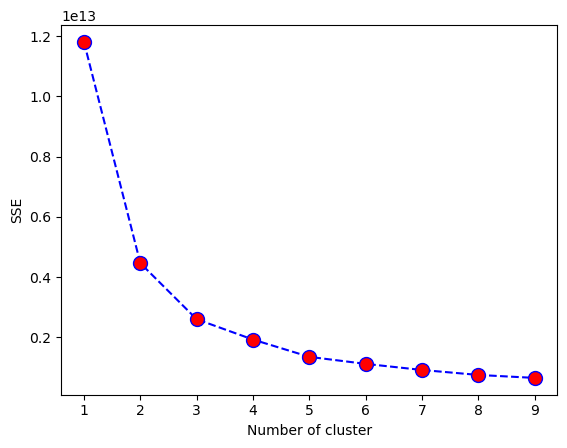

In [105]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(top_1000_defaulter_3)
    
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

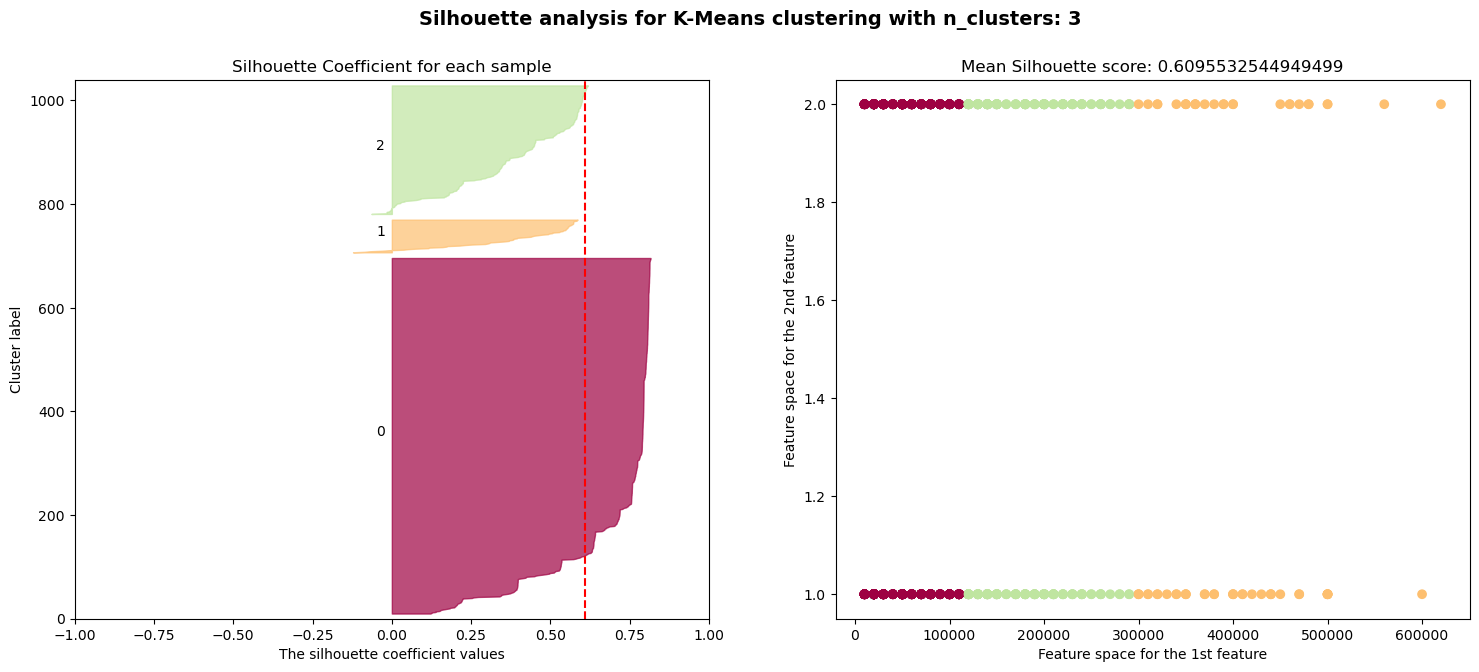

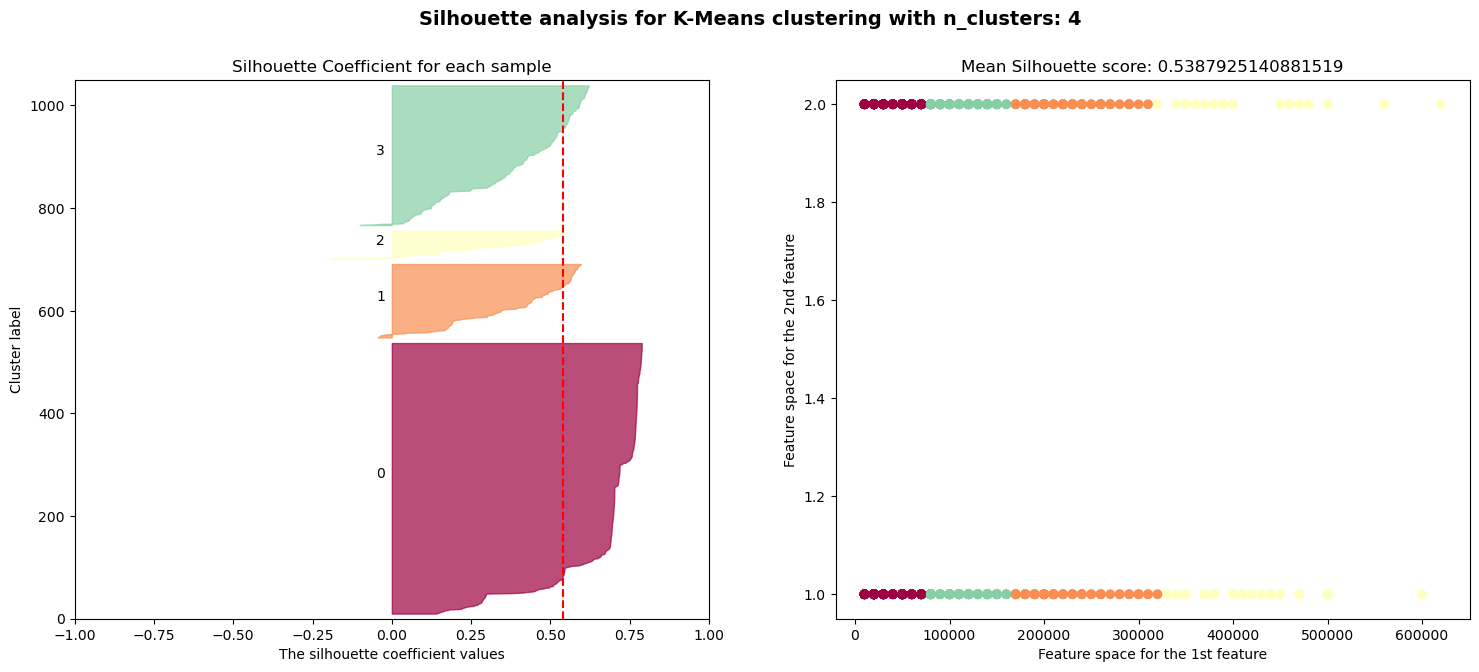

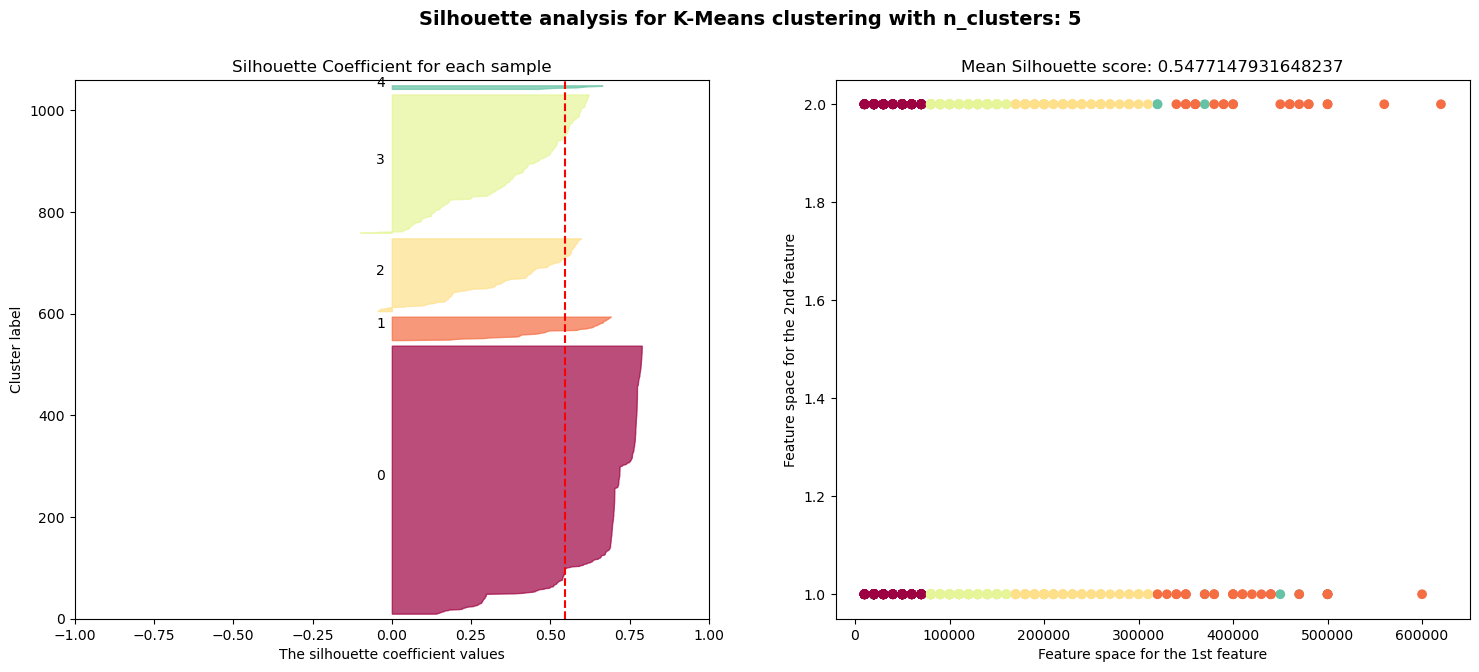

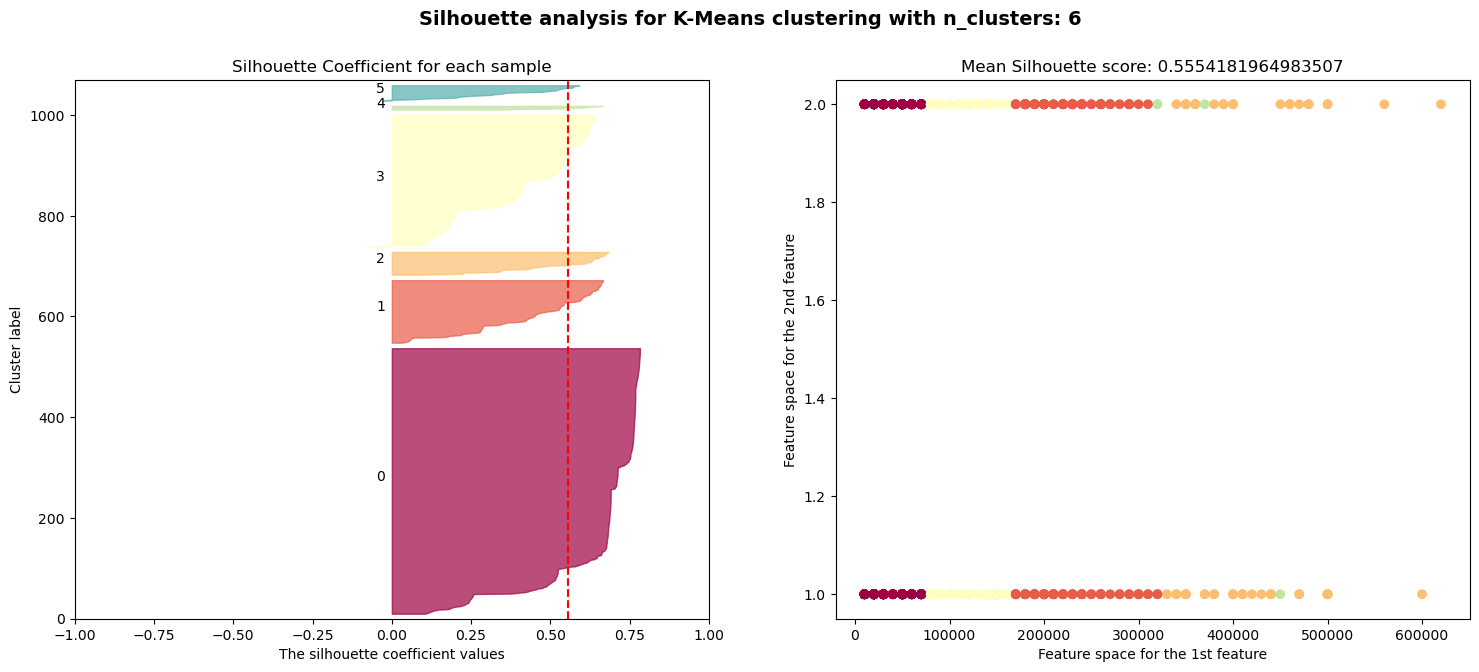

In [106]:
# X=scaled_data
X = np.array(top_1000_defaulter_3)

# List of number of clusters
range_n_clusters = [3, 4, 5, 6]

# For each number of clusters, perform Silhouette analysis and visualize the results.
for n_clusters in range_n_clusters:
    
    # Perform k-means.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    y_pred = kmeans.fit_predict(X)
    
    
    
    # Compute the Silhouette Coefficient for each sample.
    s = metrics.silhouette_samples(X, y_pred)
    
    # Compute the mean Silhouette Coefficient of all data points.
    s_mean = metrics.silhouette_score(X, y_pred)
    
    # For plot configuration -----------------------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Configure plot.
    plt.suptitle('Silhouette analysis for K-Means clustering with n_clusters: {}'.format(n_clusters),
                 fontsize=14, fontweight='bold')
    
    # Configure 1st subplot.
    ax1.set_title('Silhouette Coefficient for each sample')
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Configure 2st subplot.
    ax2.set_title('Mean Silhouette score: {}'.format(s_mean))
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    # For 1st subplot ------------------------------------------------------------------------------------------
    
    # Plot Silhouette Coefficient for each sample
    y_lower = 10
    for i in range(n_clusters):
        ith_s = s[y_pred == i]
        ith_s.sort()
        size_cluster_i = ith_s.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_s,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    # Plot the mean Silhouette Coefficient using red vertical dash line.
    ax1.axvline(x=s_mean, color="red", linestyle="--")
    
    # For 2st subplot -------------------------------------------------------------------------------------------
    
    # Plot the predictions
    colors = cmap(y_pred.astype(float) / n_clusters)
    ax2.scatter(X[:,0], X[:,1], c=colors)

In [107]:
pip install yellowbrick

     ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
     ------------------------------------- 282.6/282.6 kB 17.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


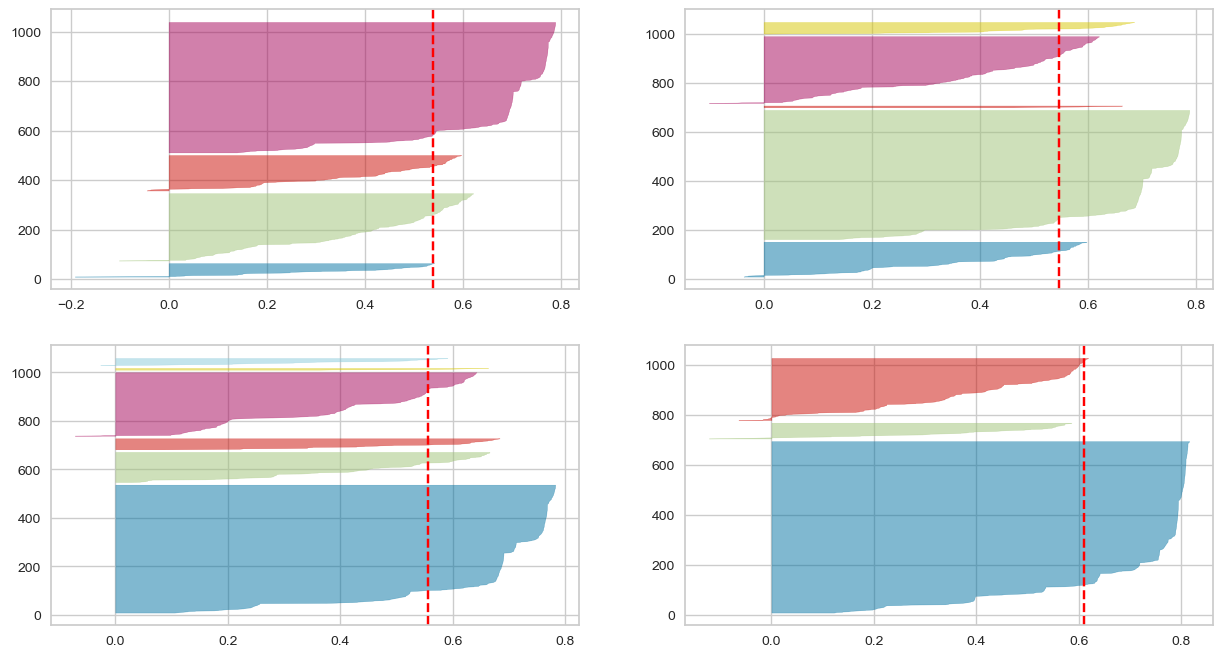

In [117]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [3, 4, 5, 6]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-2][mod])
    visualizer.fit(X)

The value of the silhouette coefﬁcient is between -1 and 1. A score of 1 denotes the best.

n=3 has the best Silhouette score of 0.6 with ~0.2 SSE.

<font style="font-family:Trebuchet MS;">
    
## Labeling the data using the selected number of clusters <a id='p5.7' />

In [122]:
data_aa_top_1000

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS,labels_n_3
3111,27264,0.838411,470000,1,3,2,37,519901,499024,494290,470617,398523,389927,0,20600,19000,14000,13600,13600,1,1,1,1,3,1,462047.000000,13466.666667,3,435890.486639,0
5578,6894,0.908720,370000,2,2,2,29,390509,382898,365461,304436,311426,275628,0,0,10019,11000,10000,10000,1,1,1,1,3,1,338393.000000,6836.500000,3,354863.461296,0
4915,27441,0.657764,500000,1,1,1,35,510367,473584,167682,501496,508213,496801,24913,5872,508229,18089,14070,15009,1,1,1,1,3,1,443023.833333,97697.000000,3,335700.957101,0
4156,24938,0.807599,450000,1,1,1,37,387192,379442,387398,395655,403568,418182,0,14062,14700,14500,21077,12575,1,1,1,1,3,1,395239.500000,12819.000000,3,312695.990530,0
4849,10433,0.573946,500000,1,1,2,49,478030,419644,309019,292878,152025,110034,205,10500,9692,4823,3986,1188,1,1,1,1,3,1,293605.000000,5065.666667,3,274363.605421,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,3365,0.104311,140000,1,2,1,28,6007,7332,7983,3277,2964,4791,7340,7983,0,2964,4800,2353,1,1,1,1,3,1,5392.333333,4240.000000,2,626.595800,1
4323,22756,0.110703,230000,2,2,1,39,5650,3798,6701,10382,4842,5792,3798,3000,5000,4842,3000,3000,1,1,1,1,3,1,6194.166667,3773.333333,2,625.473165,3
4221,18491,0.099104,40000,2,1,2,26,6223,7944,8961,3090,390,795,2000,1196,1000,1950,795,1170,1,1,1,1,3,1,4567.166667,1351.833333,1,616.721284,2
2095,8985,0.120122,30000,2,2,1,34,5088,996,888,656,1957,1536,996,0,656,1957,0,0,1,1,1,1,3,1,1853.500000,601.500000,1,611.183165,2


In [118]:
data_aa_top_1000_cluster=data_aa_top_1000

In [119]:
kmeans = KMeans(n_clusters=3,random_state=101)
kmeans.fit(top_1000_defaulter_3)
data_aa_top_1000_cluster['labels_n_3']= kmeans.labels_

In [120]:
data_aa_top_1000_cluster.groupby('labels_n_3').mean()

,ID,PROPENSITY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month,OB_1,OB_2,OB_3,Count_OB,DPD_90days,avg_bill,avg_paid,Net_worth,EXPECTED_LOSS
labels_n_3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,15119.524017,0.361190,50393.013100,1.508006,2.048035,1.577875,34.326055,34572.414847,34260.000000,32976.825328,29910.749636,27853.231441,27032.967977,2169.668122,1991.315866,1728.307132,1911.352256,1896.893741,1857.826783,1.0,1.0,0.991266,0.991266,2.982533,0.991266,31101.031538,1925.893984,1.355167,11194.317971
1,13724.301205,0.284483,178353.413655,1.546185,1.767068,1.506024,36.321285,109513.702811,106383.120482,101003.514056,90762.767068,86921.678715,84115.642570,5216.634538,4598.216867,5087.510040,6866.192771,5273.160643,6171.096386,1.0,1.0,0.967871,0.967871,2.935743,0.967871,96450.070950,5535.468541,2.104418,28971.511428
2,13382.718750,0.207683,401875.000000,1.437500,1.578125,1.515625,36.968750,224349.750000,212998.453125,198397.515625,185429.046875,177508.265625,171660.203125,9928.562500,12342.468750,18103.796875,8915.359375,12299.000000,13840.734375,1.0,1.0,0.968750,0.968750,2.937500,0.968750,195057.205729,12571.653646,3.000000,61505.038186


In [121]:
kmeans = KMeans(n_clusters=4,random_state=101)
kmeans.fit(top_1000_defaulter_3)
data_aa_top_1000_cluster['labels_n_3']= kmeans.labels_
data_aa_top_1000_cluster.to_csv("cluster3.csv")